In [1]:
# get the KITTI dataset if not there already:
!bash ../datasets/KITTI/get_files_KITTI.sh

downloading KITTI object tracking dataset ...
--2024-06-04 22:17:41--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_tracking_image_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.53, 52.219.72.107, 52.219.47.63, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15813146295 (15G) [application/zip]
Saving to: ‘data_tracking_image_2.zip’

    data_tracking_i   9%[>                   ]   1.39G  5.87MB/s    eta 38m 47s^C


In [ ]:
# using https://github.com/windowsub0406/KITTI_Tutorial/

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utils/") # Adds utils python modules path.
from kitti_foundation import Kitti, Kitti_util
%matplotlib inline

v2c_filepath = '2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '2011_09_26/calib_cam_to_cam.txt'

velo_path = '2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data'

In [7]:
velo = Kitti(frame=89, velo_path=velo_path)
frame = velo.velo_file
print(frame.shape)

AttributeError: 'generator' object has no attribute 'shape'

In [2]:
# Try to read a velodyne (Lidar) binary file:
fileName="../datasets/KITTI/training/velodyne/0002/000007.bin"
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
    print(fileContent[:10])

b'\xe1z\x9cB\xdd$\xf6@P\x8d'


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from kitti_foundation import Kitti, Kitti_util
%matplotlib inline

velo_path = '../datasets/KITTI/training/velodyne/0002/'

velo = Kitti_util(frame=100, velo_path=velo_path)
frame = velo.velo_file

print(frame.shape)

(111157, 3)


In [9]:
def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj

In [10]:
# bin file -> numpy array
velo_points = load_from_bin('../datasets/KITTI/training/velodyne/0002/000007.bin')

print(velo_points.shape)

(121644, 4)


(-0.5, 400.5, 400.5, -0.5)

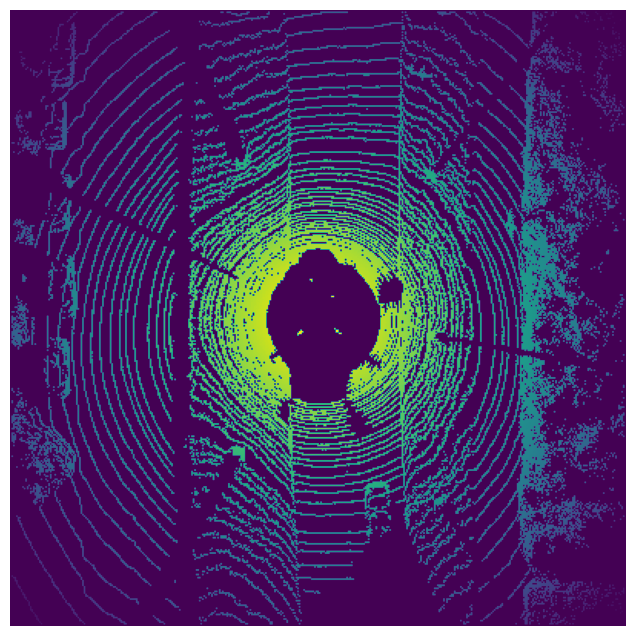

In [24]:
def normalize_depth(val, min_v, max_v):
    """ 
    print 'normalized depth value' 
    normalize values to 0-255 & close distance value has high value. (similar to stereo vision's disparity map)
    """
    return (((max_v - val) / (max_v - min_v)) * 255).astype(np.uint8)

def in_range_points(points, x, y, z, x_range, y_range, z_range):
    """ extract in-range points """
    return points[np.logical_and.reduce((x > x_range[0], x < x_range[1], y > y_range[0], \
                                         y < y_range[1], z > z_range[0], z < z_range[1]))]

def velo_points_2_top_view(points, x_range, y_range, z_range, scale):
    
    # Projecting to 2D
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2)
    
    # extract in-range points
    x_lim = in_range_points(x, x, y, z, x_range, y_range, z_range)
    y_lim = in_range_points(y, x, y, z, x_range, y_range, z_range)
    dist_lim = in_range_points(dist, x, y, z, x_range, y_range, z_range)
    
    # * x,y,z range are based on lidar coordinates
    x_size = int((y_range[1] - y_range[0]))
    y_size = int((x_range[1] - x_range[0]))
    
    # convert 3D lidar coordinates(vehicle coordinates) to 2D image coordinates
    # Velodyne coordinates info : http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
    # scale - for high resolution
    x_img = -(y_lim * scale).astype(np.int32)
    y_img = -(x_lim * scale).astype(np.int32)

    # shift negative points to positive points (shift minimum value to 0)
    x_img += int(np.trunc(y_range[1] * scale))
    y_img += int(np.trunc(x_range[1] * scale))

    # normalize distance value & convert to depth map
    max_dist = np.sqrt((max(x_range)**2) + (max(y_range)**2))
    dist_lim = normalize_depth(dist_lim, min_v=0, max_v=max_dist)
    
    # array to img
    img = np.zeros([y_size * scale + 1, x_size * scale + 1], dtype=np.uint8)
    img[y_img, x_img] = dist_lim
    
    return img

# Plot result
top_image = velo_points_2_top_view(velo_points, x_range=(-20, 20), y_range=(-20, 20), z_range=(-2, 2), scale=10)
plt.subplots(1,1, figsize = (12,8))
plt.imshow(top_image)
plt.axis('off')
    

# Velodyne overlaid on image

In [27]:
velo_points

array([[78.24 ,  7.692,  2.868,  0.   ],
       [78.21 ,  7.937,  2.867,  0.   ],
       [78.164,  8.305,  2.867,  0.   ],
       ...,
       [15.179, -5.312, -7.383,  0.84 ],
       [15.212, -5.27 , -7.391,  0.71 ],
       [15.436, -5.294, -7.493,  0.   ]], dtype=float32)

(375, 1242, 3)


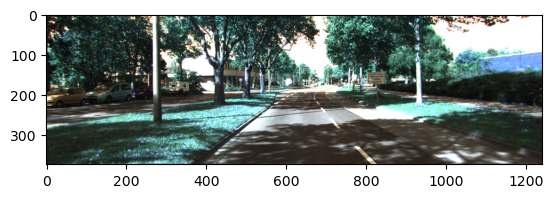

In [33]:
import matplotlib.image as mpimg

#read left camera image

image_type = 'color' # 'grayscale' or 'color' image

mode = '00' if image_type == 'grayscale' else '02' 

image = cv2.imread('../datasets/KITTI/training/image_02/0002/000000.png')
width, height = image.shape[1], image.shape[0]

plt.imshow(image)
print(image.shape)

In [44]:
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

In [36]:
""" save one frame about projecting velodyne points into camera image """
image_type = 'gray'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'graye image' , image_02 = 'color image'

image_path = 'image_' + mode + '/data'
velo_path = './velodyne_points/data'

v_fov, h_fov = (-24.9, 2.0), (-90, 90)

v2c_filepath = '../datasets/KITTI/training/calib/0002.txt'
c2c_filepath = '../datasets/KITTI/training/calib/0002.txt'

res = Kitti_util(frame=89, camera_path=image_path, velo_path=velo_path, \
                v2c_path=v2c_filepath, c2c_path=c2c_filepath)

img, pnt, c_ = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

result = print_projection_plt(pnt, c_, img)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Velodyne points to camera image Result")
plt.imshow(result)

In [39]:
v2c_filepath = '../datasets/KITTI/training/calib/0002.txt'
c2c_filepath = '../datasets/KITTI/training/calib/0002.txt'

In [41]:
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

image_type = 'color' # 'grayscale' or 'color' image
mode = '00' if image_type == 'grayscale' else '02' # image_00 = 'grayscale image' , image_02 = 'color image'

# image = cv2.imread('image_'+ mode +'/data/0000000089.png')
image = cv2.imread('../datasets/KITTI/training/image_02/0002/000000.png')

ans, c_ = velo3d_2_camera2d_points(velo_points, v_fov=(-24.9, 2.0), h_fov=(-45,45), \
                               vc_path=v2c_filepath, cc_path=c2c_filepath, mode=mode)

image = print_projection_plt(points=ans, color=c_, image=image)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Velodyne points to camera image Result")
plt.imshow(image)

ValueError: not enough values to unpack (expected 2, got 1)

In [43]:
velo_points, (-24.9, 2.0), (-45,45), v2c_filepath, c2c_filepath, mode

(array([[78.24 ,  7.692,  2.868,  0.   ],
        [78.21 ,  7.937,  2.867,  0.   ],
        [78.164,  8.305,  2.867,  0.   ],
        ...,
        [15.179, -5.312, -7.383,  0.84 ],
        [15.212, -5.27 , -7.391,  0.71 ],
        [15.436, -5.294, -7.493,  0.   ]], dtype=float32),
 (-24.9, 2.0),
 (-45, 45),
 '../datasets/KITTI/training/calib/0002.txt',
 '../datasets/KITTI/training/calib/0002.txt',
 '02')